# Ground-Touching Detection

## Type Conversion
[pascal voc xml to csv table](https://gist.github.com/rotemtam/88d9a4efae243fc77ed4a0f9917c8f6c)

In [171]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
from tqdm import tqdm 

def xml2csv():
    image_path = os.path.join(os.getcwd(), 'Annotations')
    xml_list = []
    invalid_xml_list = []
    for xml_file in tqdm(glob.glob(image_path + '/*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        objects = root.findall('object')
        for _obj in objects:
            flag = True
            bbx = _obj.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = _obj.find('name').text
            group_code = xml_file[-17:-10]
            Full_name =  group_code+"_"+root.find('filename').text
            value = (Full_name,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
        if not objects:
            invalid_xml_list.append(xml_file)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    if xml_list: # empty list check
        xml_df = pd.DataFrame(xml_list, columns=column_name)
        xml_df.to_csv(f'labels.csv', index=None)
        print(f'        "labels.csv" has been created at {os.getcwd()}.')
    if invalid_xml_list: # Invalid means no object in the xml
        invalid_xml_df = pd.DataFrame(invalid_xml_list)
        invalid_xml_df.to_csv(f'invalid_labels.csv', index=None, header=None)
        print(f'"invalid_labels.csv" has been created at {os.getcwd()}.')
    print(f'Successfully converted xml to csv. {len(invalid_xml_list)} invalid labels has been detected.')

In [172]:
import os

os.chdir("D:/GIT_REPOS/2021-NCKU_NN/Project3_final/group1_8")
os.getcwd()
xml2csv()

100%|██████████| 27885/27885 [00:05<00:00, 4988.58it/s]


        "labels.csv" has been created at D:\GIT_REPOS\2021-NCKU_NN\Project3_final\group1_8.
"invalid_labels.csv" has been created at D:\GIT_REPOS\2021-NCKU_NN\Project3_final\group1_8.
Successfully converted xml to csv. 187 invalid labels has been detected.


## Image Name

### Read CSV label

In [2]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np

os.chdir("D:/GIT_REPOS/2021-NCKU_NN/Project3_final/group1_8")
df_xml = pd.read_csv('labels.csv')
# Inverse y axis
df_xml['ymin'] = 1080 - df_xml['ymin']
df_xml['ymax'] = 1080 - df_xml['ymax']
# Insert column: group
df_xml.insert(0, 'group', [int(f[5:7]) for f in df_xml['filename'].to_list()])
# Calculate dx, dy
df_xml['dx'] = df_xml['xmax'] - df_xml['xmin']
df_xml['dy'] = df_xml['ymax'] - df_xml['ymin']

### Delete redundant labels

In [3]:
df_id = df_xml['filename']
print('Total :', df_xml.shape[0])
print('Unique:', df_id.nunique())

dup_xml = df_xml[df_id.isin(df_id[df_id.duplicated()])].sort_values('filename')
dup_xml.to_csv('dup_xml.csv', index=False)

# Group 5: Delete the static badminton on RHS
ind_del = dup_xml.loc[(dup_xml['group'] == 5) &( dup_xml['xmax'] > 1300)].index

# Group 7 : Delete the super small bbx
# Group 8 : Delete the super large bbx
dup7_8 = dup_xml.loc[(dup_xml['group'] == 7) | (dup_xml['group'] == 8)].copy()
dup7_8['dx'] = dup7_8['xmax'] - dup7_8['xmin']
dup7_8['dy'] = dup7_8['ymax'] - dup7_8['ymin']
ind_del = ind_del.append(dup7_8.loc[(dup7_8['dx'] > 100) | (dup7_8['dy'] > 100)].index)
ind_del = ind_del.append(dup7_8.loc[(dup7_8['dx'] < 3) | (dup7_8['dy'] < 3)].index)

# Delete redundant
df_xml = df_xml.drop(ind_del).reset_index(drop=True)
df_xml

Total : 27791
Unique: 27698


,group,filename,width,height,class,xmin,ymin,xmax,ymax,dx,dy
0,1,group01_00376.jpg,1920,1080,badminton,645,749,669,730,24,-19
1,1,group01_00377.jpg,1920,1080,badminton,652,769,677,744,25,-25
2,1,group01_00378.jpg,1920,1080,badminton,657,782,679,757,22,-25
3,1,group01_00379.jpg,1920,1080,badminton,662,801,689,767,27,-34
4,1,group01_00380.jpg,1920,1080,badminton,667,811,692,786,25,-25
...,...,...,...,...,...,...,...,...,...,...,...
27690,8,group08_04296.jpg,1920,1080,badminton,1093,652,1102,642,9,-10
27691,8,group08_04297.jpg,1920,1080,badminton,1092,651,1101,642,9,-9
27692,8,group08_04298.jpg,1920,1080,badminton,1089,651,1104,643,15,-8
27693,8,group08_04299.jpg,1920,1080,badminton,1091,652,1102,643,11,-9


### Create Timeline Dataframe

In [9]:
import glob

os.chdir("D:/GIT_REPOS/2021-NCKU_NN/Project3_final/group1_8")
img_files = glob.glob(os.getcwd() + '/Images/*.jpg')
img_files = [i[-17:] for i in img_files]
data = {
    'filename': img_files,
    'width': np.nan,
    'height': np.nan,
    'class': np.nan,
    'xmin': np.nan,
    'ymin': np.nan,
    'xmax': np.nan,
    'ymax': np.nan
}
df = pd.DataFrame(data=data)
# Add group number column
group_num = [int(f[5:7]) for f in df['filename'].to_list()]
# Insert column: group
df.insert(0, 'group', group_num)
# df.insert(1, 'time', [int(f[-9:-4]) for f in df['filename'].to_list()])
df.to_csv('timeline_org.csv')

### Merge Timeline with Valid Labels

In [15]:
print('Timeline:', df.shape[0])
df_full = pd.concat([df_xml, df], ignore_index=True) # Need unique index
delete = df_full[df_full['filename'].duplicated()]
print('delete  :', delete.shape[0])
df_full = df_full.drop(delete.index)
print('df_full :', df_full.shape[0])
df_full = df_full.sort_values(['filename']).reset_index(drop=True)

# Add x, y center
df_full['x_c'] = (df_full['xmin'] + df_full['xmin'])/2
df_full['y_c'] = (df_full['ymin'] + df_full['ymin'])/2

# Add x, y velocity
vx = np.append(np.diff(df_full['x_c'].to_numpy()), [0])
vy = np.append(np.diff(df_full['y_c'].to_numpy()), [0])
vx_filter = vx.copy()
vx_filter[np.abs(vx_filter) > 0.0001] = np.nan
df_full['vx'] = vx*10 + 1000
df_full['vy'] = vy*10 + 1000
df_full['vx_filter'] = vx_filter*50000
valid = ~np.isnan(df_full['xmin'])
df_full.insert(0, 'valid', valid)
df_full.to_csv('df_full.csv', index=False)
df_full

Timeline: 40295
delete  : 27695
df_full : 40295


,valid,group,filename,width,height,class,xmin,ymin,xmax,ymax,dx,dy,x_c,y_c,vx,vy,vx_filter
0,False,1,group01_00375.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,1,group01_00376.jpg,1920.0,1080.0,badminton,645.0,749.0,669.0,730.0,24.0,-19.0,645.0,749.0,1070.0,1200.0,NaN
2,True,1,group01_00377.jpg,1920.0,1080.0,badminton,652.0,769.0,677.0,744.0,25.0,-25.0,652.0,769.0,1050.0,1130.0,NaN
3,True,1,group01_00378.jpg,1920.0,1080.0,badminton,657.0,782.0,679.0,757.0,22.0,-25.0,657.0,782.0,1050.0,1190.0,NaN
4,True,1,group01_00379.jpg,1920.0,1080.0,badminton,662.0,801.0,689.0,767.0,27.0,-34.0,662.0,801.0,1050.0,1100.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40290,True,8,group08_04296.jpg,1920.0,1080.0,badminton,1093.0,652.0,1102.0,642.0,9.0,-10.0,1093.0,652.0,990.0,990.0,NaN
40291,True,8,group08_04297.jpg,1920.0,1080.0,badminton,1092.0,651.0,1101.0,642.0,9.0,-9.0,1092.0,651.0,970.0,1000.0,NaN
40292,True,8,group08_04298.jpg,1920.0,1080.0,badminton,1089.0,651.0,1104.0,643.0,15.0,-8.0,1089.0,651.0,1020.0,1010.0,NaN
40293,True,8,group08_04299.jpg,1920.0,1080.0,badminton,1091.0,652.0,1102.0,643.0,11.0,-9.0,1091.0,652.0,990.0,990.0,NaN


3801
X.shape = (3801, 4)
Y.shape = (3801, 2)


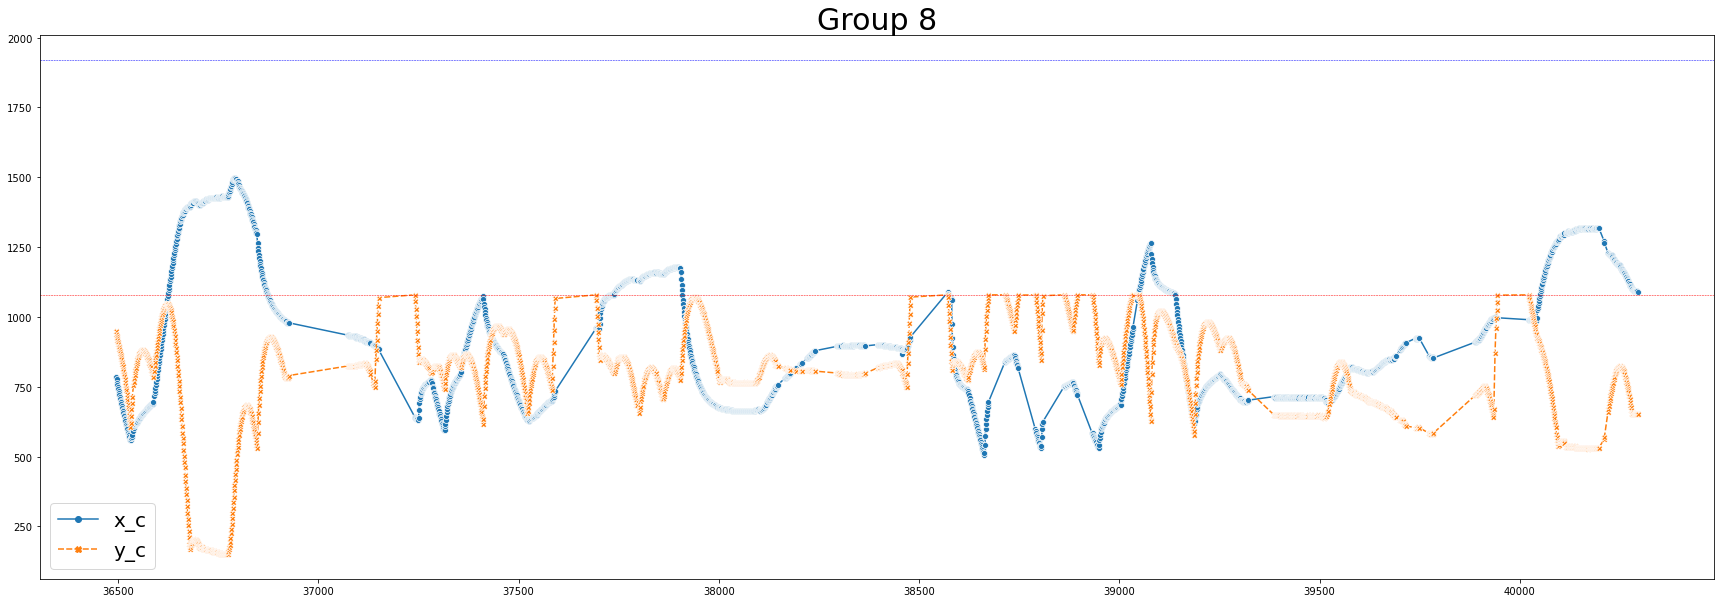

In [325]:
group_code = 8
_df = df_full.loc[df_full['group'] == group_code][['x_c', 'y_c']]
print(_df.shape[0])
X = np.tile(np.arange(_df.shape[0]),(4, 1)).T
Y = _df.to_numpy()
print(f'X.shape = {X.shape}')
print(f'Y.shape = {Y.shape}')

fig = plt.figure(figsize=(30, 10))
# plt.plot(np.arange(_df.shape[0]), Y, '.')
ax = sns.lineplot(data=_df, markers=True, linestyle='').set_title(f'Group {group_code}', fontsize=30)
plt.legend(fontsize='20')
plt.axhline(y=1920, color='b', linestyle='--', linewidth=0.5)
plt.axhline(y=1080, color='r', linestyle='--', linewidth=0.5)

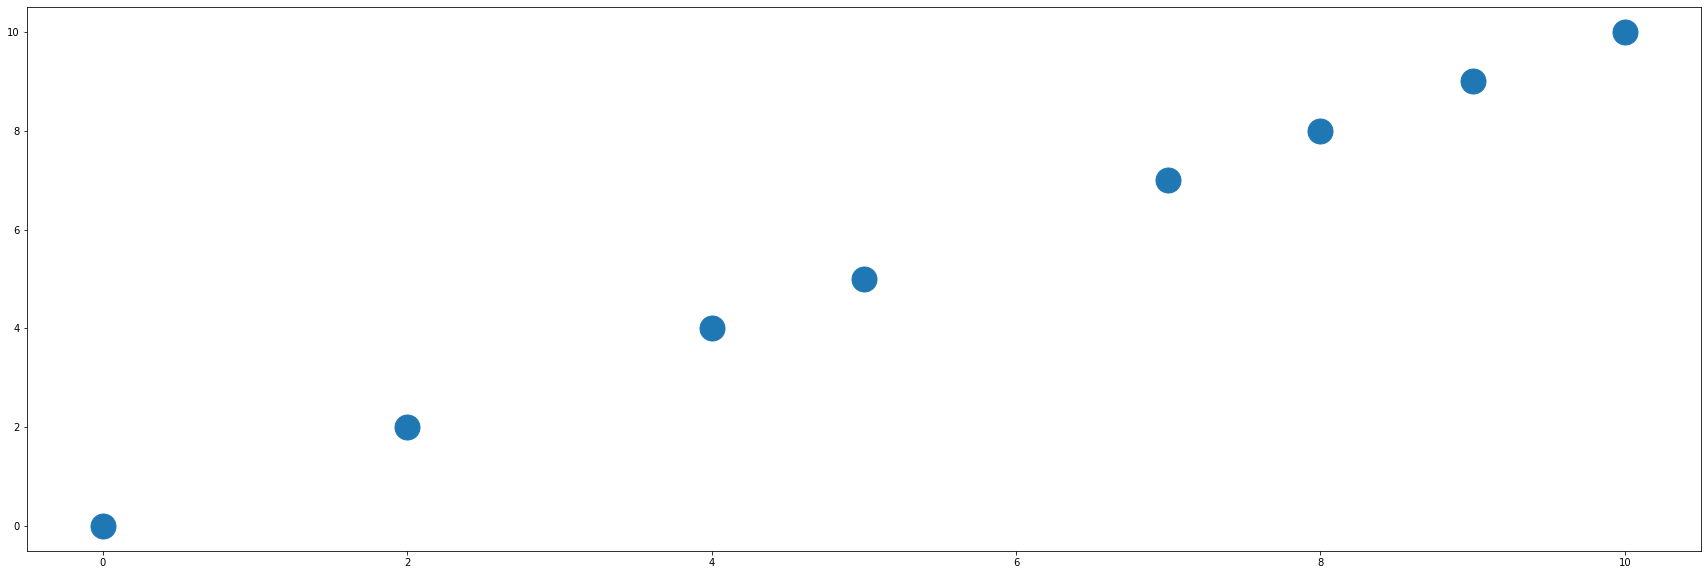

In [144]:
x = np.linspace(0, 10, 11)
y = np.linspace(0, 10, 11)
y[[1, 3, 6]] = np.nan
fig = plt.figure(figsize=(30, 10))
plt.plot(x, y, '.', markersize=50)